In [1]:
#!/bin/bash/python

#180205 METHOD 2 
    #query for overlap of roadmap active enhancer dataset in Villar hliver data.
        #datasets must overlap >50% of one fragment (roadmap or villar) with other fragment (roadmap or villar)
    #The purpose of this query is to identify private/shared Villar hliver enhancers among roadmap tissues. 
    #Active enhancers in Villar's dataset present in any roadmap tissue may validate those fragments as bona fide enhancers.

#180206 - FUTURE DIRECTION: relaxed enhancer definition should  be used to recapitulate Villar's method for identifying enhancers. 

#180130 the purpose of this script is to ask how many enhancers identified by Villar histone modifications in human liver overlap enhancers identified in roadmap human livers identified by those same histone modifications.

# Villar Enhancer = H3K27ac+ H3K4me3- with no/ <50% overlap with H3K4me3 ChIP-SEQ dataset.

#'s' = 'stringent' enhancers where H3K27ac modifications absolutely do not overlap H3K4me3 modification fragments.(H3K27ac+/H3K4me3-)
#'r' = 'relaxed' enhancers here H3K27ac modifications do not overlap H3K4me3 modification fragments, or do with less than 50% overlap (H3K27ac+/H3K4me3<50%)


In [2]:
import os, sys
import pandas
import glob
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
plt.style.use('seaborn-deep')
today = datetime.date.today()

In [80]:
#gather enhancers made from Make_roadmap_bedfiles.ipynb

roadmap_path = "/dors/capra_lab/users/fongsl/roadmap/stringent/"
result_path = "%sresults/" %roadmap_path

print(roadmap_path)
print(result_path)

os.system("mkdir %s" %result_path)
os.chdir(roadmap_path)

roadmap_datasets= sorted(glob.glob("Hsap*.bed"))

# Dictionary of E00*.bed:2018-01-2*.bed
roadmap_datasets_dict= dict((i.split("_")[5], "%s%s" % (roadmap_path, i)) for i in roadmap_datasets) 


/dors/capra_lab/users/fongsl/roadmap/stringent/
/dors/capra_lab/users/fongsl/roadmap/stringent/results/


In [7]:
# load villar human enhancers
# documentation for Villar /dors/capra_lab/projects/enhancer_uniqueness/data2/villar15/README

villar="/dors/capra_lab/projects/enhancer_uniqueness/data2/villar15/combinedPeakCalls/HSap_H3K4me3.H3K27Ac_overlap_H3K27Aconly.bed"

v = pandas.read_table(villar, header =-1)
print(len(v))
v.columns=["v-chr", "v-start", "v-end", "IDs"]
v.head()

29177


,v-chr,v-start,v-end,IDs
0,chr20,270226,272388,hsaH3K27Ac23366
1,chr20,289482,291606,hsaH3K27Ac23368
2,chr20,342933,346519,hsaH3K27Ac23371
3,chr20,346432,347763,hsaH3K27Ac23372
4,chr20,350157,354996,hsaH3K27Ac23373


In [18]:
# Dataframe to count Villar overlap in each Roadmap sample
df = pandas.DataFrame(columns= ["tissue","num_roadmap","num_villar","num_villar_u", "overlap", "overlap_u"])

for tissue, tissue_file in roadmap_datasets_dict.items():
    tissue = tissue.replace(".bed", "") #
    
    # make unique file for Villar x Roadmap overlap
    outfile = "%svillar_enh_x_%s.bed" % (result_path, tissue) 
            
    # BED INTERSECTION - Villar X Roadmap (E00x)
    # -f = 50% fragment overlap. When used with '-e', either Villar or Roadmap must have at least 50% overlap. 
    # -e = either fragment
    # -wa = boundaries of Villar fragment
    # -wb = boundaries of Roadmap fragment
    
    bed_cmd = "bedtools intersect -a %s -b %s -f 0.5 -e -wa -wb > %s" % (villar, tissue_file, outfile)
    #print(bed_cmd)
    #os.system(bed_cmd)
        
    #question - how much does villar overlap each roadmap sample?
    #measure frequency of villar sample/roadmap sample
    
    tissue_enh_count = len(pandas.read_table(tissue_file,header =-1))
    villar_enh_count = len(pandas.read_table(outfile, header =-1))
    villar_u_enh_count = len(pandas.read_table(outfile, header =-1)[3].unique())
    overlap = (villar_enh_count/tissue_enh_count)
    overlap_u = (villar_u_enh_count/tissue_enh_count)

    df2 = pandas.DataFrame([[tissue, tissue_enh_count, villar_enh_count, villar_u_enh_count, overlap, overlap_u]], columns= ["tissue","num_roadmap","num_villar","num_villar_u", "overlap", "overlap_u"])
    df = pandas.concat([df2, df])

In [19]:
df.head()

,tissue,num_roadmap,num_villar,num_villar_u,overlap,overlap_u
0,E129,30691,4035,3853,0.131472,0.125542
0,E128,26056,6704,6386,0.257292,0.245088
0,E127,17964,2486,2406,0.138388,0.133935
0,E126,20762,5011,4726,0.241354,0.227627
0,E125,28776,3885,3730,0.135008,0.129622


In [20]:
#Why unique analysis? Villar fragments may overlap >1 roadmap fragments.

#output file example

test = pandas.read_table("%svillar_enh_x_E003.bed"%result_path, header =-1)

print(len(test[3]))
print(len(test[3].unique()))# the last column is the number of peaks reported in E006 sample. 

7007
6236


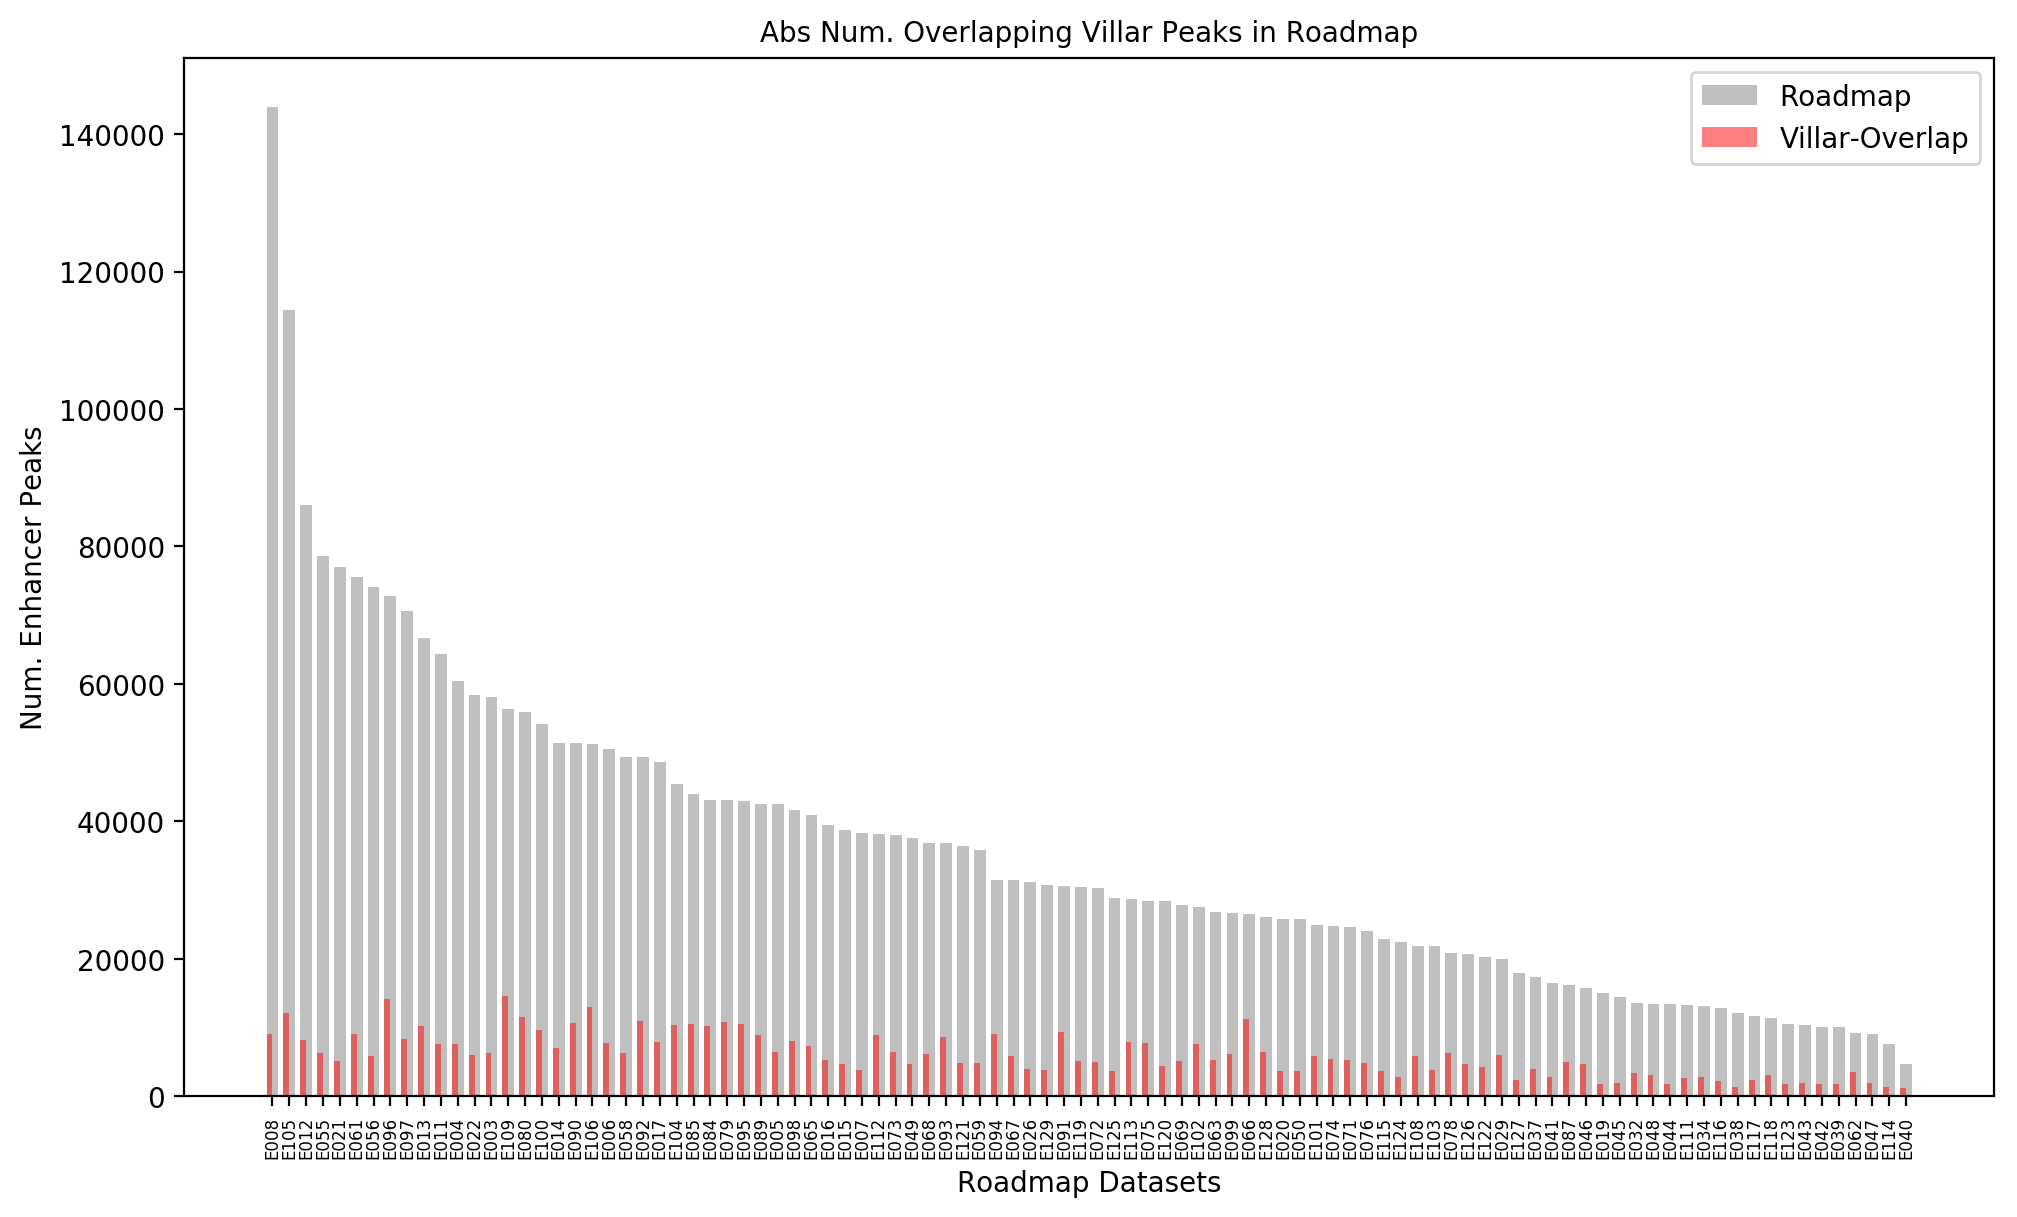

In [21]:
#### Horizontal Bar Plot VILLAR ENHANCER OVERLAP PER ROADMAP TISSUE  ####

width = 0.7 
indices = np.arange(len(df["tissue"]))
df = df.sort_values(by ="num_roadmap", ascending = False)

plt.figure(num=None, figsize=(10,6), dpi=200, facecolor='w', edgecolor='k')

plt.bar(indices, df["num_roadmap"], width, color = 'k', label = 'Roadmap', alpha = 0.25)
plt.bar([(i-0.25*width) for i in indices], df["num_villar_u"], 0.5*width, color = 'r', alpha = 0.5, label = 'Villar-Overlap') #Unique Villar Enhancers

plt.xticks(indices,[i for i in df["tissue"]], fontsize = 6, rotation=90)
plt.yticks(fontsize = 10)
plt.ylabel("Num. Enhancer Peaks", fontsize = 10)
plt.xlabel("Roadmap Datasets", fontsize = 10)
plt.title("Abs Num. Overlapping Villar Peaks in Roadmap", fontsize = 10)
plt.legend(fontsize = 10)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

plt.savefig("%s/%s_villar_overlap_bar_abs.pdf" % (result_path,today))
plt.show()
plt.close()

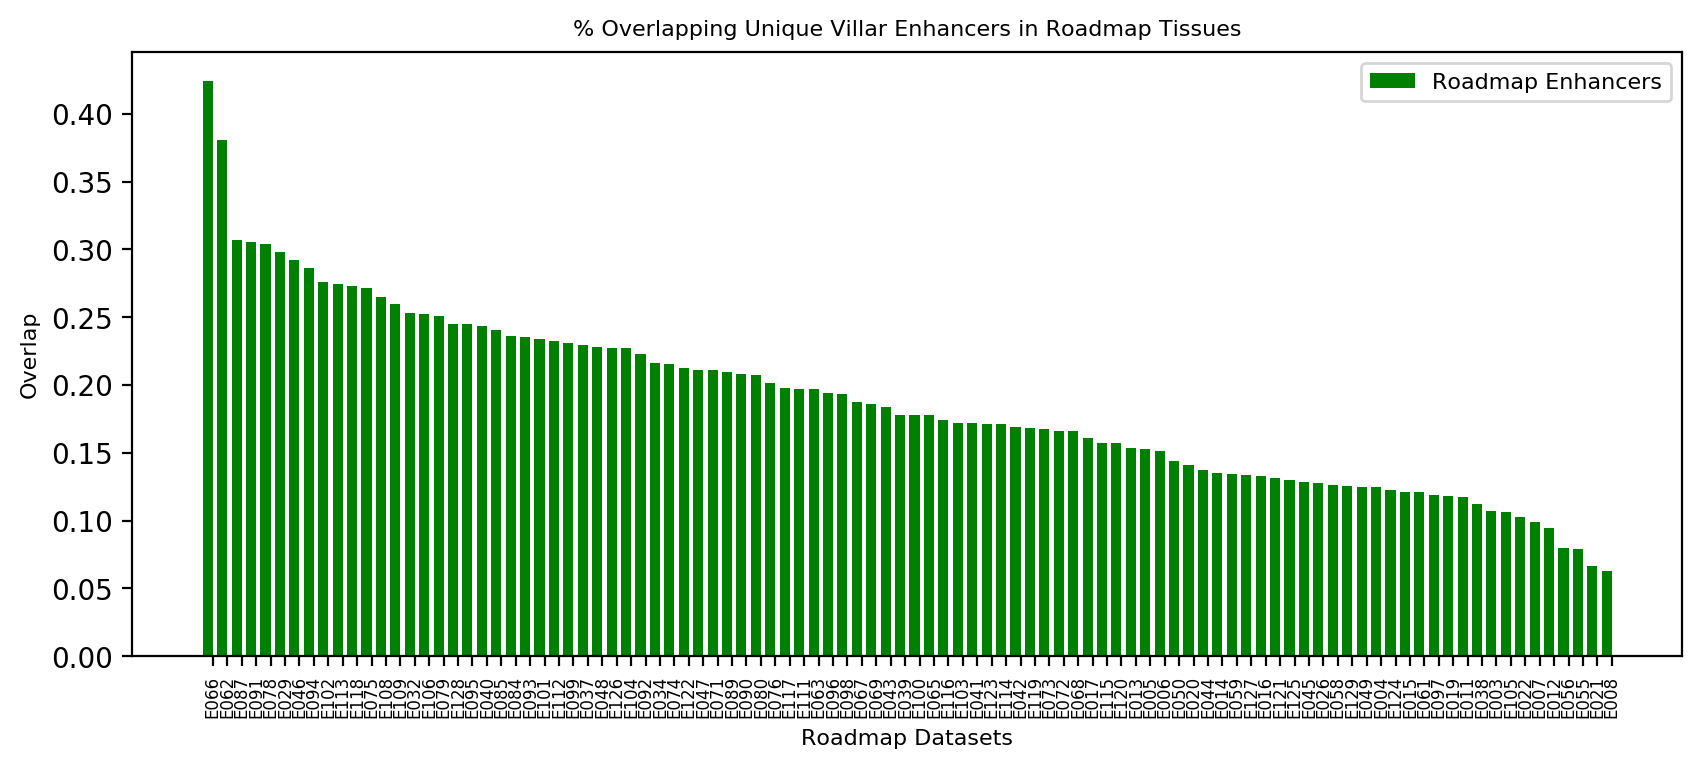

In [22]:
#### Horizontal Bar Plot FREQUENCY OF VILLAR OVERLAP PER ROADMAP TISSUE ####
df= df.sort_values(by ="overlap_u", ascending = False)
plt.figure(num=None, figsize = (10,4), dpi=200, facecolor= 'w', edgecolor ='k')

plt.bar(indices, df["overlap_u"], width, color = 'g', label = 'Roadmap Enhancers')
#plt.barh(indices, df["overlap_u"], width, color = 'g', label = 'Villar Enhancers')

plt.xticks(indices+0.5*width,[i for i in df["tissue"]], fontsize = 6, rotation = 90)
#plt.yticks(indices,[i for i in df["tissue"]], fontsize = 5)

plt.ylabel("Overlap", fontsize=8)

plt.xlabel("Roadmap Datasets", fontsize=8)
plt.legend(fontsize=8)
plt.title("% Overlapping Unique Villar Enhancers in Roadmap Tissues", fontsize=8)

plt.savefig("%s/%s_villar_overlap_bar_freq.pdf" % (result_path,today))
plt.show()

In [78]:
## INTERSECT ALL VILLAR ACTIVE ENHANCERS PER ROADMAP TISSUE TO FIND COMMONLY OVERLAPPING ENHANCERS#####

#use datatables containing only villar unique ID information. 
any_tissue_enhancer=glob.glob("%svillar_enh_x_E*.bed"%result_path)

#use villar dataframe as base for evaluating overlap
results = v
print(len(results))

29177


In [79]:
# build a data frame containing all the overlapping tissue for each villar 
for tissue in any_tissue_enhancer:

    df= pandas.read_table(tissue, header =-1)

    tissue_id = (tissue.split("_")[4]).split(".")[0]

    #name the columns
    df.columns = ["%s-chr-v" %tissue_id, "%s-start-v"%tissue_id, "%s-end-v"%tissue_id, "IDs","%s-chr-r" %tissue_id, "%s-start-r"%tissue_id, "%s-end-r"%tissue_id, "%s-peakcount-r"%tissue_id]

    #get unique Villar IDs overlapping Roadmap Tissue E00X
    df_u = df[["%s-chr-v" %tissue_id, "%s-start-v"%tissue_id, "%s-end-v"%tissue_id, "IDs"]]
    df_u= df_u.drop_duplicates(['IDs'])

    #label the Villar ID's in Roadmap Sample
    df_u["%s"%tissue_id] = 1

    #merge overlapping villar-roadmap ids back to villar-reference.
    results = pandas.merge(results, df_u[["IDs","%s" %tissue_id]], how = "left", on = "IDs")

In [82]:
results.head()

,v-chr,v-start,v-end,IDs,E104,E113,E120,E094,E049,E046,...,E093,E061,E012,E112,E032,E005,E040,E126,E118,E038
0,chr20,270226,272388,hsaH3K27Ac23366,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr20,289482,291606,hsaH3K27Ac23368,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr20,342933,346519,hsaH3K27Ac23371,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,1.0,NaN
3,chr20,346432,347763,hsaH3K27Ac23372,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN
4,chr20,350157,354996,hsaH3K27Ac23373,1.0,NaN,NaN,NaN,1.0,NaN,...,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0


In [83]:
a = results.columns[4:]
results["sum"] = results[a].sum(axis =1)
print("max overlap ", results["sum"].max())
b = results["sum"].quantile(0.9) # the zeros do not change the 90th % cut off of overlapping datasets. 
print("no samples in 90th%", b)
results_90 = results.loc[results["sum"]>= b]
results_90["90_percentile"] = 1 # create a column that marks enhancers in the 90th%. 1 = 90th% enhancer, 0 = enhancer is not in 90th%

results_merged = pandas.merge(results, results_90[["IDs","90_percentile"]], how = "left", on = "IDs")
results_merged = results_merged.fillna(0) # fill in the rest of the 90th% genes with zeros

results_merged.to_csv("%svillar_x_any_roadmap.bed" % (result_path), sep = '\t', index = False, header = True) #save 90th% without villar species merge.

results_90[["v-chr","v-start", "v-end"]].to_csv("%svillar_x_roadmap_90th_coordinates.bed" % (result_path), sep = '\t', index = False, header = False) # save dataframe

max overlap  80.0
no samples in 90th% 40.0


/opt/easybuild/software/Core/Anaconda3/4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


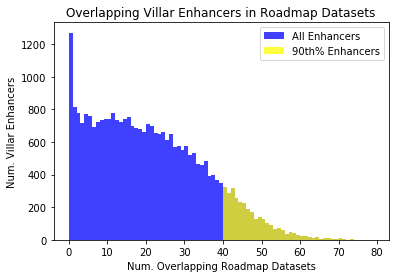

In [84]:
hist_data = results_merged["sum"]
hist90_data = results_merged["sum"].loc[results_merged["90_percentile"]==1]
indices = np.arange(results_merged["sum"].max())
data,bins,patches = plt.hist(hist_data, indices, facecolor = "blue", alpha = 0.75, label = "All Enhancers")
data,bins,patches = plt.hist(hist90_data, indices, facecolor = "yellow", alpha = 0.75, label = "90th% Enhancers")

plt.xlabel("Num. Overlapping Roadmap Datasets")
plt.ylabel("Num. Villar Enhancers")
plt.title("Overlapping Villar Enhancers in Roadmap Datasets")
plt.legend()
plt.savefig("%sall_villar_x_roadmap_overlap.pdf" %(result_path))
plt.show()
plt.close()

data = [hist_data, hist90_data]
datatype = "Roadmap Villar Overlap"
labels = ["all enh", "90th% enh"]
#histogram(data, indices, datatype, labels, 10)

In [85]:
print(results_merged["sum"].head())

print("max overlap ", results_merged["sum"].max())


0     0.0
1     2.0
2    24.0
3    14.0
4    45.0
Name: sum, dtype: float64
max overlap  80.0
